In [10]:
#packages
import numpy as np
import numpy.random as npr
from scipy.stats import norm
from keras.layers import Input, Dense, Concatenate
from keras.models import Model
from keras import backend as kb
import matplotlib.pyplot as plt
%run Path_simulation.ipynb #imports path simulation functions
plt.style.use('ggplot')

In [11]:
#parameters
mu = 0.00
r = 0
sigma = 0.2
steps = 30
S0 = 100
n = 100000
K = 100
T = 30/365
dt = T/steps
TC=False

In [12]:
#defining functions and calculating call price.
def BlackScholes(S0,r,sigma,T,K):#time zero price
    d1 =  1 / (sigma * np.sqrt(T)) * (np.log(S0/K) + (r+sigma**2/2)*T)
    d2 = d1 - sigma * np.sqrt(T)
    return norm.cdf(d1) * S0 - norm.cdf(d2) * K * np.exp(-r*T)
callprice = BlackScholes(S0,r,sigma,T,K)
def BlackScholesCallDelta(S0,r,sigma,tau,K):
    d1 =  1 / (sigma * np.sqrt(tau)) * (np.log(S0/K) + (r+sigma**2/2)*tau)
    return norm.cdf(d1)

In [13]:
S1 = BlackScholesPath(n)
tSinput,dS = DataInputOutput_BS(S1)

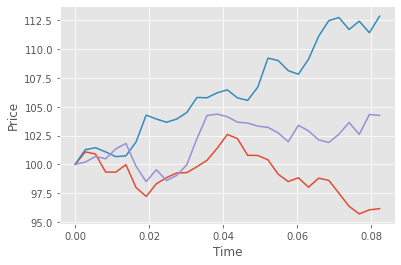

In [14]:
#This just plots the three first stock paths as a sanity check

tim = np.linspace(0,T,steps+1)#Vector of timepoint where pf i adjusted.

plt.plot(tim,S1[0],tim,S1[1],tim,S1[2])
plt.xlabel("Time")
plt.ylabel("Price")
plt.show()

In [15]:
#loss function. In this case a Quadratic loss. 
def loss_call(y_true,y_pred):
    return (callprice + kb.sum(y_pred * y_true,axis=-1) - kb.maximum(S0 + kb.sum(y_true,axis=-1) - K,0.))**2

inputs = []
predictions = []

#Network structure
layer1 = Dense(100, activation='relu')
layer2 = Dense(100, activation='relu')
layer3 = Dense(100, activation='relu')
layer4 = Dense(1, activation='linear')

#Structure of network
for i in range(steps):
    sinput = Input(shape=(2,))
    x = layer1(sinput)
    x = layer2(x)
    x = layer3(x)
    sprediction = layer4(x)
    inputs.append(sinput)#inserts input in input vector
    predictions.append(sprediction)#inserts preditions in prediction vector
    
#Builds the model
predictions = Concatenate(axis=-1)(predictions)
model = Model(inputs=inputs, outputs=predictions)
#model.summary()
model.compile(optimizer='adam', loss=loss_call, metrics=[])

In [16]:
model.fit(tSinput,dS,batch_size=100,epochs=20)

Epoch 1/20
1000/1000 [==============================] - 40s 33ms/step - loss: 3.0061
Epoch 2/20
1000/1000 [==============================] - 38s 38ms/step - loss: 2.9344
Epoch 3/20
1000/1000 [==============================] - 33s 33ms/step - loss: 2.8929
Epoch 4/20
1000/1000 [==============================] - 28s 28ms/step - loss: 2.8378
Epoch 5/20
1000/1000 [==============================] - 24s 24ms/step - loss: 2.5401
Epoch 6/20
1000/1000 [==============================] - 23s 23ms/step - loss: 0.8591
Epoch 7/20
1000/1000 [==============================] - 24s 24ms/step - loss: 0.3117
Epoch 8/20
1000/1000 [==============================] - 24s 24ms/step - loss: 0.2708
Epoch 9/20
1000/1000 [==============================] - 23s 23ms/step - loss: 0.2316
Epoch 10/20
1000/1000 [==============================] - 25s 25ms/step - loss: 0.2417
Epoch 11/20
1000/1000 [==============================] - 24s 24ms/step - loss: 0.2080
Epoch 12/20
1000/1000 [==============================] - 25s 25

In [17]:
#model.save('BlackScholes')

# Plot

In [18]:
#First load model if we just use the last one.
#model = keras.models.load_model('BlackScholes')

In [ ]:
#first evaluate model on new dataset.
S2 = BlackScholesPath(n)
input_eval,dS_eval = DataInputOutput_BS(S2)

In [25]:
deltas_NN=model.predict(input_eval)

3125/3125 [==============================] - 16s 5ms/step


In [26]:
deltas_analytic=np.zeros((n,steps))
timv = np.linspace(0,T,steps+1)
for i in range(n):
    for j in range(steps):
        deltas_analytic[i][j]=BlackScholesCallDelta(S2[i][j],r,sigma,T-timv[j],K)

In [27]:
payoff=np.maximum(S2.T[steps]-K,0)
#network
PfValue_NN=callprice+np.sum(dS_eval*deltas_NN,axis=-1)
Error_NN=PfValue_NN-payoff#What we get in the bank
#analytic
PfValue_analytic=callprice+np.sum(dS_eval*deltas_analytic,axis=-1)
Error_analytic=PfValue_analytic-payoff#What we get in the bank

### Histogram

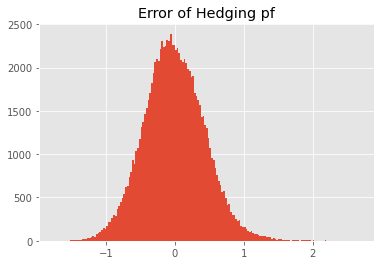

In [28]:
#(np.histogram(Error,bins=100))
a = np.hstack(-Error_NN)
_ = plt.hist(a, bins='auto')  # arguments are passed to np.histogram
plt.title("Error of Hedging pf")
plt.show()

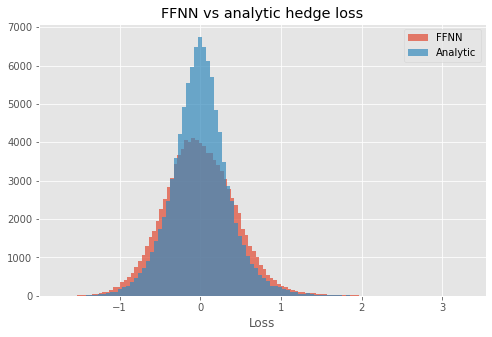

In [31]:
bins = np.linspace(0, 5, 100)
plt.hist(-Error_NN,100,alpha=0.7,label='FFNN')
plt.hist(-Error_analytic,100,alpha=0.7,label='Analytic')
plt.legend(loc='upper right')
plt.title("FFNN vs analytic hedge loss")
plt.xlabel("Loss")

figure = plt.gcf()
figure.set_size_inches(8, 5)

#plt.savefig("Plots/Hist_BS_FFNN_Analytic.png")
plt.show()

### Hockey stick

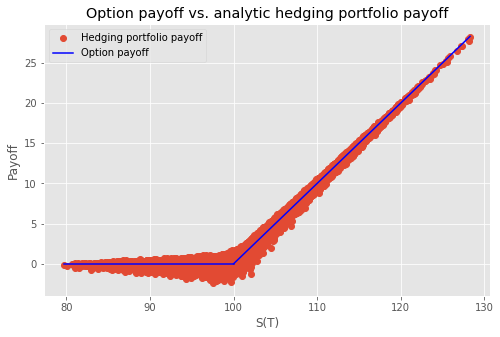

In [52]:
x=S2.T[steps]#This is X-axis
y=PfValue_analytic#This is y-axis
min_S=np.min(x)
max_S=np.max(x)
plt.plot(x,y,'o',label="Hedging portfolio payoff")
plt.plot([min_S, K], [0, 0],color='b')
plt.plot([K, max_S], [0, max_S-S0],color='b',label="Option payoff")
plt.legend(loc='upper left')
plt.title("Option payoff vs. analytic hedging portfolio payoff")
plt.xlabel("S(T)")
plt.ylabel("Payoff")
figure = plt.gcf()
figure.set_size_inches(8, 5)

plt.savefig("Plots/Hockey_BS_analytic.png")
plt.show()

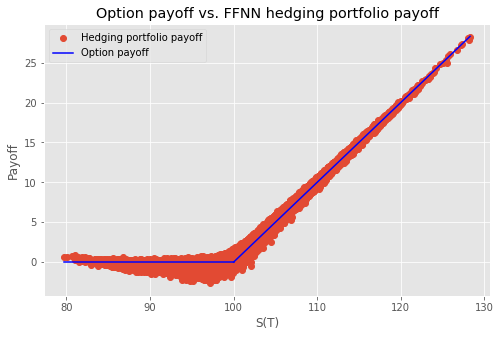

In [53]:
x=S2.T[steps]#This is X-axis
y=PfValue_NN#This is y-axis
min_S=np.min(x)
max_S=np.max(x)
plt.plot(x,y,'o',label="Hedging portfolio payoff")
plt.plot([min_S, K], [0, 0],color='b')
plt.plot([K, max_S], [0, max_S-S0],color='b',label="Option payoff")
plt.legend(loc='upper left')
plt.title("Option payoff vs. FFNN hedging portfolio payoff")
plt.xlabel("S(T)")
plt.ylabel("Payoff")
figure = plt.gcf()
figure.set_size_inches(8, 5)

plt.savefig("Plots/Hockey_BS_FFNN.png")
plt.show()

### Other metrics

In [35]:
#Analytic
print('Mean of Hedge error is: ',np.mean(-Error_analytic))
print('sd of hedge error is: ',np.std(Error_analytic))
print('MSE of hedge error is: ',np.mean(Error_analytic**2))

Mean of Hedge error is:  0.0002263137073106869
sd of hedge error is:  0.360354325802552
MSE of hedge error is:  0.12985529134250592


In [36]:
#FFNN
print('Mean of Hedge error is: ',np.mean(-Error_NN))
print('sd of hedge error is: ',np.std(Error_NN))
print('MSE of hedge error is: ',np.mean(Error_NN**2))

Mean of Hedge error is:  -0.004932727664680034
sd of hedge error is:  0.4413026857461801
MSE of hedge error is:  0.19477239224900572


### 2D

1/1 [==============================] - 0s 313ms/step


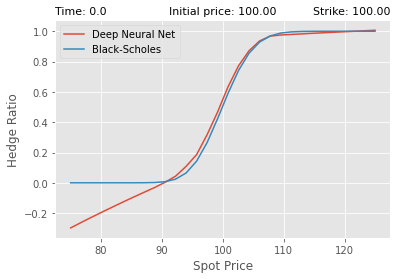

In [47]:
#This is all for plotting 
time = T*0.5
tStest = []
Sval = np.linspace(75,125,num=steps)
for i in range(steps):
    z = (time,np.log(Sval[i]))
    z = np.reshape(z,(1,2))
    tStest.append(z)

    
    
Delta_learn = np.reshape(model.predict(tStest),(steps,))
Delta_BS = BlackScholesCallDelta(Sval,mu,sigma,T-time,K)
line_learn = plt.plot(Sval,Delta_learn,label="Deep Neural Net")
line_BS = plt.plot(Sval,Delta_BS, label="Black-Scholes")
plt.xlabel("Spot Price")
plt.ylabel("Hedge Ratio")
plt.title(r'Time: %1.1f' % time, loc='left', fontsize=11)
plt.title(r'Strike: %1.2f' % K, loc='right', fontsize=11)
plt.title(r'Initial price: %1.2f' % S0, loc='center', fontsize=11)
plt.legend()
#plt.show()
plt.savefig("deephedge.png", dpi=150)
plt.savefig("deephedge.pdf")

# 3D 

In [38]:
#¤make the code flexible so it can handle S_idx and t_idx being adjusted...
S_idx=steps
t_idx=steps

Sval = np.linspace(95,105,num=S_idx)
tval = np.linspace(T/4,T/4*3,num=t_idx)

SGrid,tGrid=np.meshgrid(Sval,tval)

In [39]:
#Neural Network 3D plot values
#% make sure this is done right...
tSinput_3d = []
tim = np.linspace(T/2,T/2,steps+1)

n_3d=1

#¤is this range right? or should we switch S_idx and t_idx so they get the opposite i,j
for i in range(S_idx):
    for j in range(t_idx):
        timv = np.reshape(tGrid[i][j],(1,1))
        Sv = np.reshape(np.log(SGrid[i][j]),(1,1))
        tSinput_3d.append(np.concatenate((timv,Sv),1))#Input is (t,S,v)


delta_NN = np.zeros([steps,steps])

for i in range(steps):
    delta_3d=model.predict(tSinput_3d[i*30:i*30+30])
    for j in range(steps):
        delta_NN[i][j]=delta_3d[0][j]
    
    
    
#delta1_NN = np.zeros([steps,steps])
#delta2_NN = np.zeros([steps,steps])

#for i in range(steps):
 #   delta_3d=model_FFNN_NoTC.predict(tSinput_3d[i*30:i*30+30])
  #  delta_3d_1=delta_3d[0][::2]
   # delta_3d_2=delta_3d[0][1::2]
   # for j in range(steps):
    #    delta1_NN[i][j]=delta_3d_1[j]
     #   delta2_NN[i][j]=delta_3d_2[j]

1/1 [==============================] - 0s 117ms/step


In [40]:
#Analytic 3D plot values

delta_model = np.zeros([steps,steps])

for i in range(steps):
    for j in range(steps):
        delta=BlackScholesCallDelta(np.exp(tSinput_3d[i*steps+j][0][1]),r,sigma,T-tSinput_3d[i*steps+j][0][0],K)
        delta_model[i][j]=delta
#delta1_model = np.zeros([steps,steps])
#delta2_model = np.zeros([steps,steps])

#for i in range(steps):
#    for j in range(steps):
 #       delta1,delta2=delta12(t=tSinput_3d[i*steps+j][0][0],s=tSinput_3d[i*steps+j][0][1],v=tSinput_3d[i*steps+j][0][2])
  #      delta1_model[i][j]=delta1
   #     delta2_model[i][j]=delta2

In [41]:
#Diff 3D plot values
delta_diff=delta_NN-delta_model
#delta1_diff=delta1_NN-delta1_model
#delta2_diff=delta2_NN-delta2_model

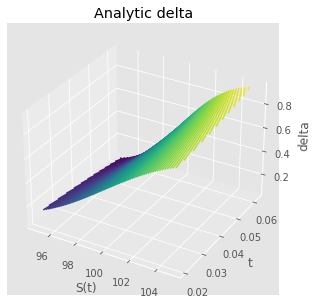

In [49]:
fig_nn = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(SGrid, tGrid, delta_model, 100)
ax.set_xlabel('S(t)')
ax.set_ylabel('t')
ax.set_zlabel('delta');
plt.title("Analytic delta")
#ax.view_init(-160, 80)
figure = plt.gcf()
figure.set_size_inches(5, 5)
plt.savefig('Plots/3d_analytic_BS')

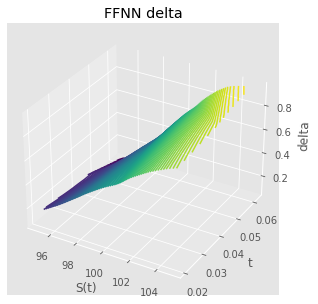

In [50]:
fig_nn = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(SGrid, tGrid, delta_NN, 100)
ax.set_xlabel('S(t)')
ax.set_ylabel('t')
ax.set_zlabel('delta');
plt.title("FFNN delta")
#ax.view_init(-160, -140)
figure = plt.gcf()
figure.set_size_inches(5, 5)
plt.savefig('Plots/3d_FFNN_BS')

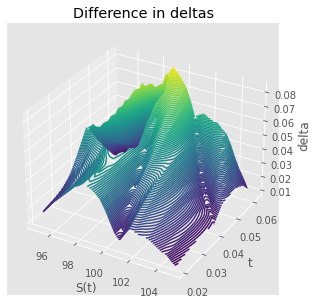

In [51]:
fig_model = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(SGrid, tGrid, delta_diff, 100)
ax.set_xlabel('S(t)')
ax.set_ylabel('t')
ax.set_zlabel('delta');
plt.title("Difference in deltas")
#ax.view_init(-160, 80)
figure = plt.gcf()
figure.set_size_inches(5, 5)
plt.savefig('Plots/3d_diff_BS')

In [45]:
np.min(delta_diff)

0.008111301182822661

In [46]:
np.max(delta_diff)

0.08496440500873953